# Diffraction

Diffraction with circle aperture

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # this is for surface plots
from matplotlib import cm
from PIL import Image, ImageDraw
from astropy.io import fits
%matplotlib inline

Opitical Parameters

All units are in SI!!!!

In [94]:
pupilcenter=(0,0,0)

focalcenter=(1,0,0)

lambdacenter=0.45e-6
lambdawide=0.15e-6

Useful TF functions

In [95]:
def ft2d(func):
    ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(func)))
    return ft

def ift2d(func):
    ift = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(func)))
    return ift

def ft1d_freq(x):
    """Calculate the (spatial) frequency array based on the spatial array x."""
    s = np.fft.fftshift(np.fft.fftfreq(x.size, d=x[-1]-x[-2]))
    return s

def zoom(im, x, y, bb):
    """Cut out a square box from image im centered on (x,y) with half-box size bb."""
    return(im[y-bb:y+bb,x-bb:x+bb])

def padcplx(c, pad=4):
    """Puts a Complex array in the centre of a zero-filled Complex array.
    pad defines the padding multiplier for the output array."""
    (nx, ny) = c.shape
    bignx = nx * pad + 1
    bigny = ny * pad + 1
    big_c = np.zeros((bignx, bigny), dtype=complex)
    
    dx = int((nx * (pad-1)) / 2 + 1)
    dy = int((ny * (pad-1)) / 2 + 1)
    
    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

In [96]:
#Plotting function!

def multi_plot(func, title):
    #Some fancy stuff  
    plt.figure(figsize=(50, 10))
    plt.axis('equal')
    font = {' - size'   : 55}

    plt.subplot(1, 5, 1)
    plt.imshow(np.abs(func))
    plt.colorbar()
    plt.title(title+' - Amplitude')

    plt.subplot(1, 5, 2)
    plt.imshow(np.log(np.abs(func)**2))
    plt.colorbar()
    plt.title(title+' - log(I) aka log(PSF)')

    plt.subplot(1, 5, 3)
    plt.imshow(np.real(func),cmap='RdBu')
    plt.colorbar()
    plt.title(title+' - Real part')

    plt.subplot(1, 5, 4)
    plt.imshow(np.imag(func),cmap='RdBu')
    plt.colorbar()
    plt.title(title+' - Imaginary part')

    plt.subplot(1, 5, 5)
    plt.imshow(np.angle(func) ,cmap='RdBu')
    plt.colorbar()
    plt.title(title+' - Phase')
    return()

Pupile plan

1 Form

2 Amplitude

3 Phase

Text(0.5, 1.0, 'Aperture')

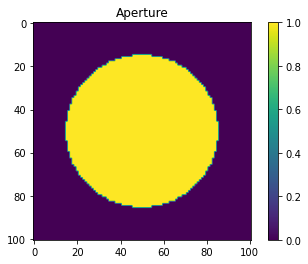

In [97]:
#Amplitude
#Grids
npix = 101 #FFT need a centering grid put a ODD
grid=np.full(shape=(npix,npix),fill_value=1)



# Define a function for a circular aperture
def circle_mask(im, xc, yc, rcirc):
    """Create a circular aperture centered on (xc, yc) with radius rcirc."""
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    circ = (newx-xc)**2 + (newy-yc)**2 < rcirc**2
    return circ.astype('float')

rad = 0.7 * npix/2

def hexagone_mask(im, xc, yc):
#https://stackoverflow.com/posts/3732128/edit
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    h=npix/4
    
    x1=xc+h
    x2=xc+0.5*h
    x3=xc-0.5*h
    x4=xc-h
    x5=xc-0.5*h
    x6=xc+0.5*h
    y1=yc
    y2=yc+h*np.sqrt(3/2)
    y3=yc+h*np.sqrt(3/2)
    y4=yc
    y5=yc-h*np.sqrt(3/2)
    y6=yc-h*np.sqrt(3/2)
      
    polygon = [(x1,y1),(x2,y2),(x3,y3),(x4,y4),(x5,y5),(x6,y6)]
    width = npix
    height = npix

    #Create image and convert to array
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    img=grid*img

    return img

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


aperture=circle_mask(grid, int(npix/2), int(npix/2), rad)
#aperture=hexagone_mask(grid, int(npix/2), int(npix/2))

#aperture=fits.getdata('../../JWST_pupil.fits')
#npix=len(aperture)
#grid=np.full(shape=(npix,npix),fill_value=1) #JWST


plt.imshow(aperture)
plt.colorbar()
plt.title('Aperture')

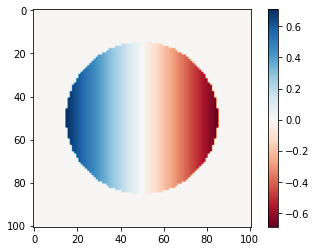

In [99]:
def zernike (Az, xc, yc, grid, norma):
    zer=grid*0
    
    lin = np.linspace(0-xc, npix-xc, npix)
    xx, yy = np.meshgrid(lin, lin)

    rho=np.sqrt(xx**2+yy**2)
    rho/=norma
    theta=-np.arctan2(yy,-xx)
    
    #TODO Generalizeit!
    Z=[1,
       2*rho*np.cos(theta),2*rho*np.sin(theta),
       np.sqrt(6)*rho**2*np.cos(2*theta),np.sqrt(3)*(rho**2-1),np.sqrt(6)*rho**2*np.sin(2*theta)]
    for i in range (len(Az)):
        zer=zer+Az[i]*Z[i]
    return zer

Az=[0,1,0,0,0,0]

xc=int(npix/2)+npix%2
yc=xc
rad=len(aperture)


phi=zernike(Az, xc, yc, grid, rad)*aperture

plt.imshow(aperture)
plt.imshow(phi,cmap='RdBu')
plt.colorbar()

C:\Users\dbourgeois\Miniconda3\envs\foufourier\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


()

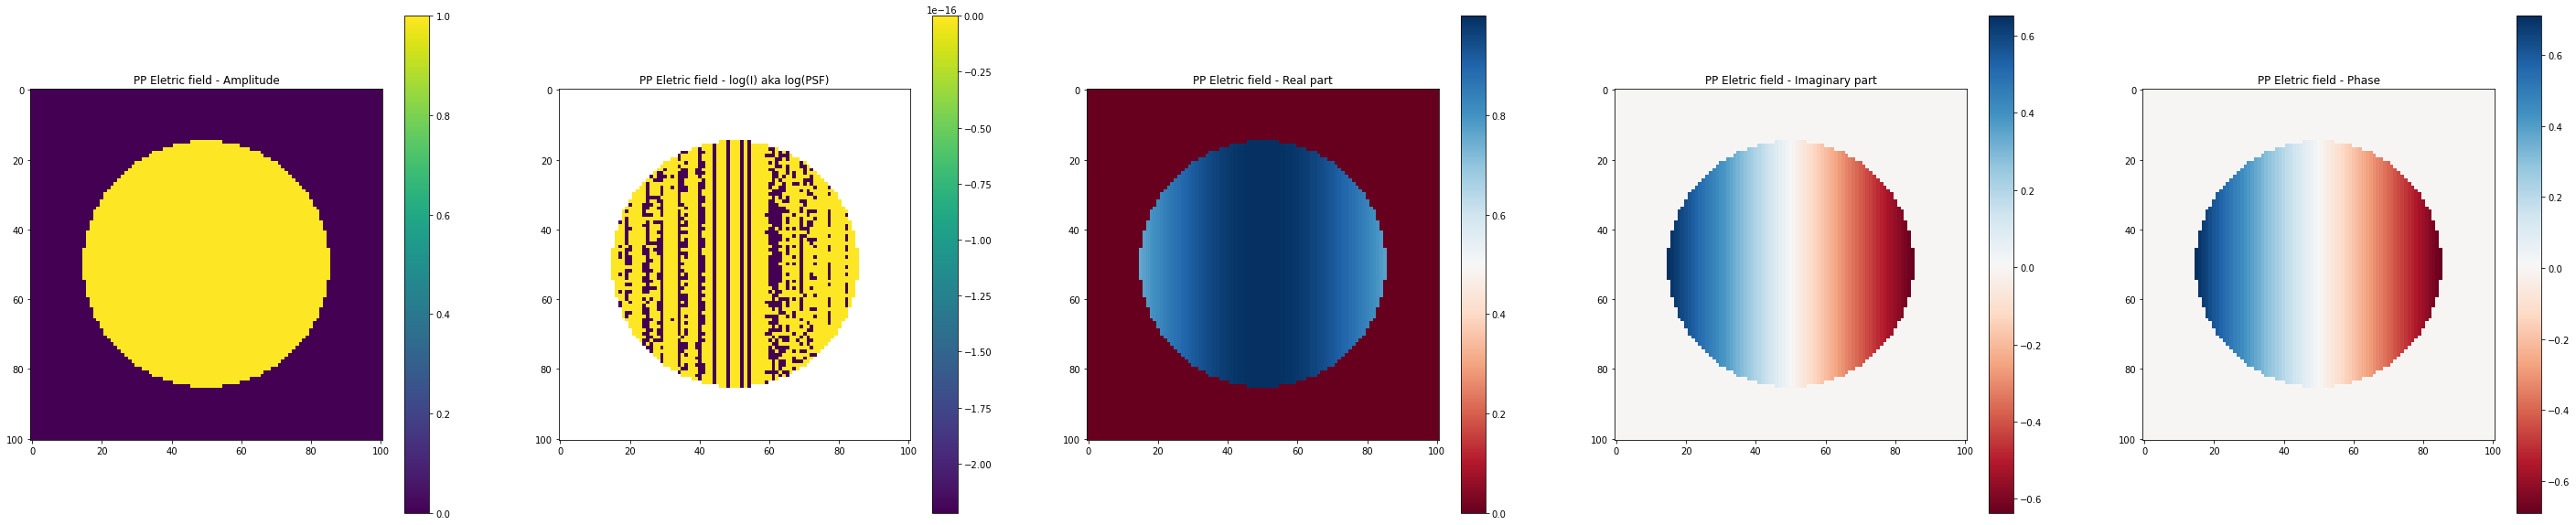

In [100]:
#Electrical Field afetr aperture
Efield=aperture*np.exp(1j*phi)

multi_plot(Efield, "PP Eletric field")


Focal plan

1 TF aperture

2 Make coronaph aperture

3 Multiply TF and coronagraph

()

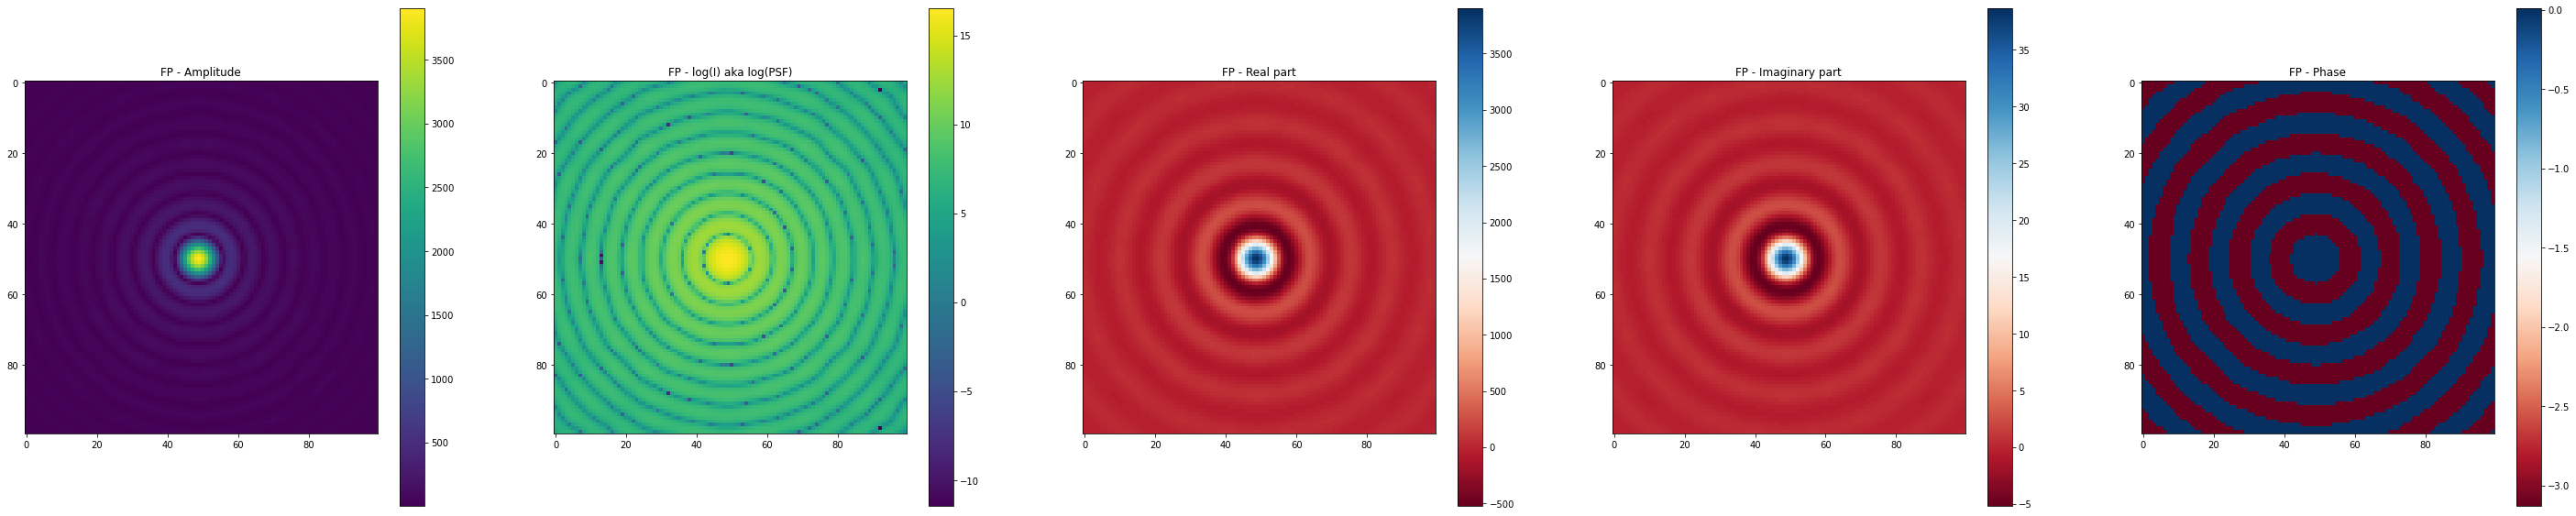

In [101]:
focalplan_BC = ft2d(padcplx(Efield))

#Box rezize
pad = 5
npix_pad = npix*pad+1   # figure out the padded big array sizes after the FT
zoomfac =10     # half-size of the zoom box will be 1/zoomfac of total image
box = int(npix_pad/zoomfac)
# This is a smaller data array wiht our region of interest.
focalplan_BC_zoom = zoom(focalplan_BC, int(focalplan_BC.shape[0]/2), int(focalplan_BC.shape[0]/2), box)

multi_plot(focalplan_BC_zoom, "FP")

#Coronagraph




C:\Users\dbourgeois\Miniconda3\envs\foufourier\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


()

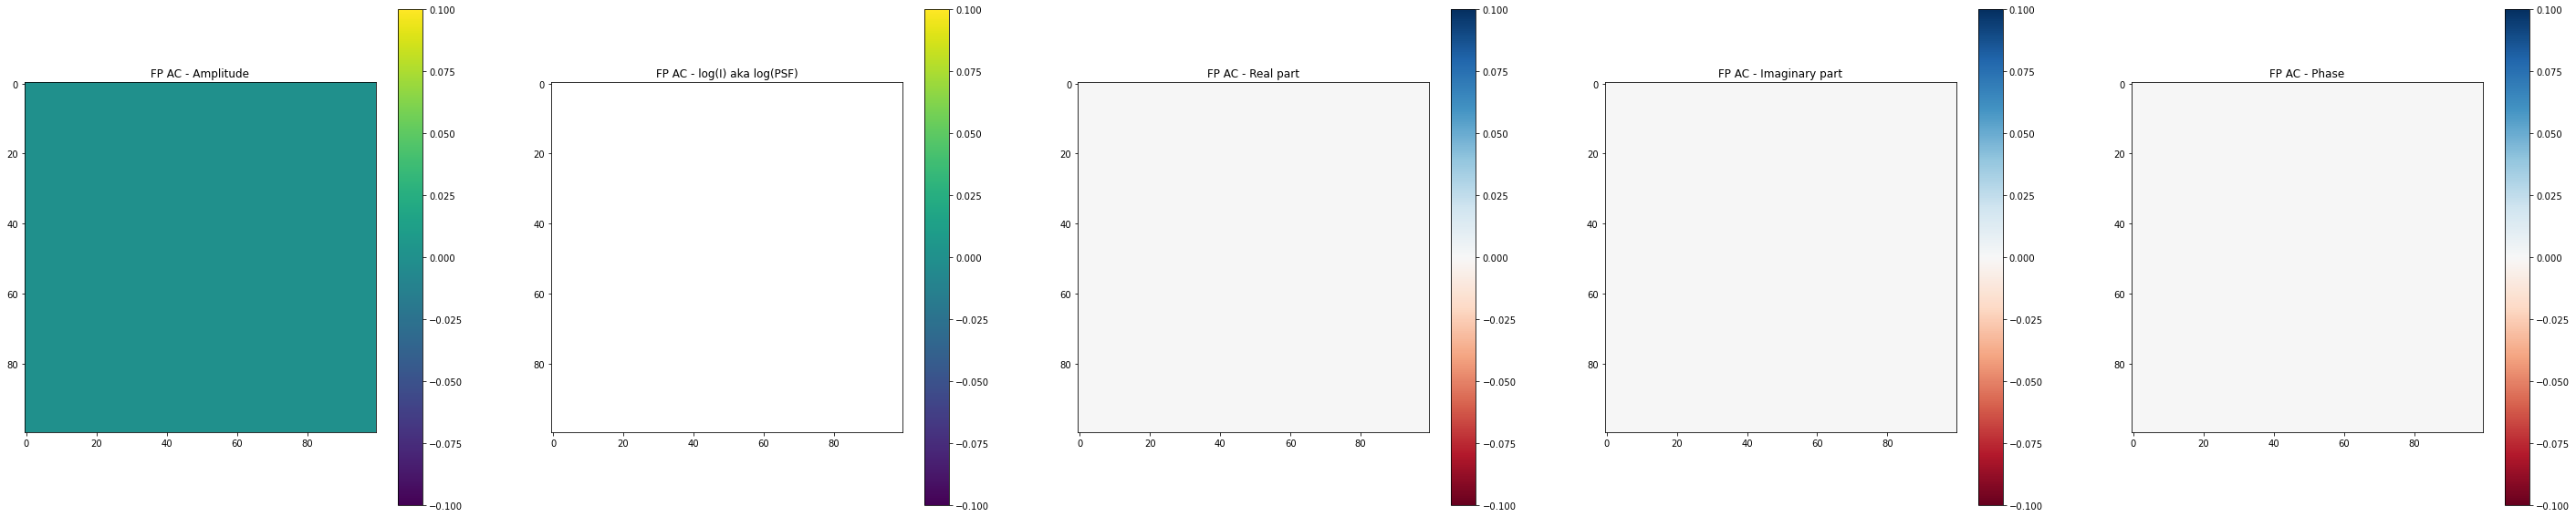

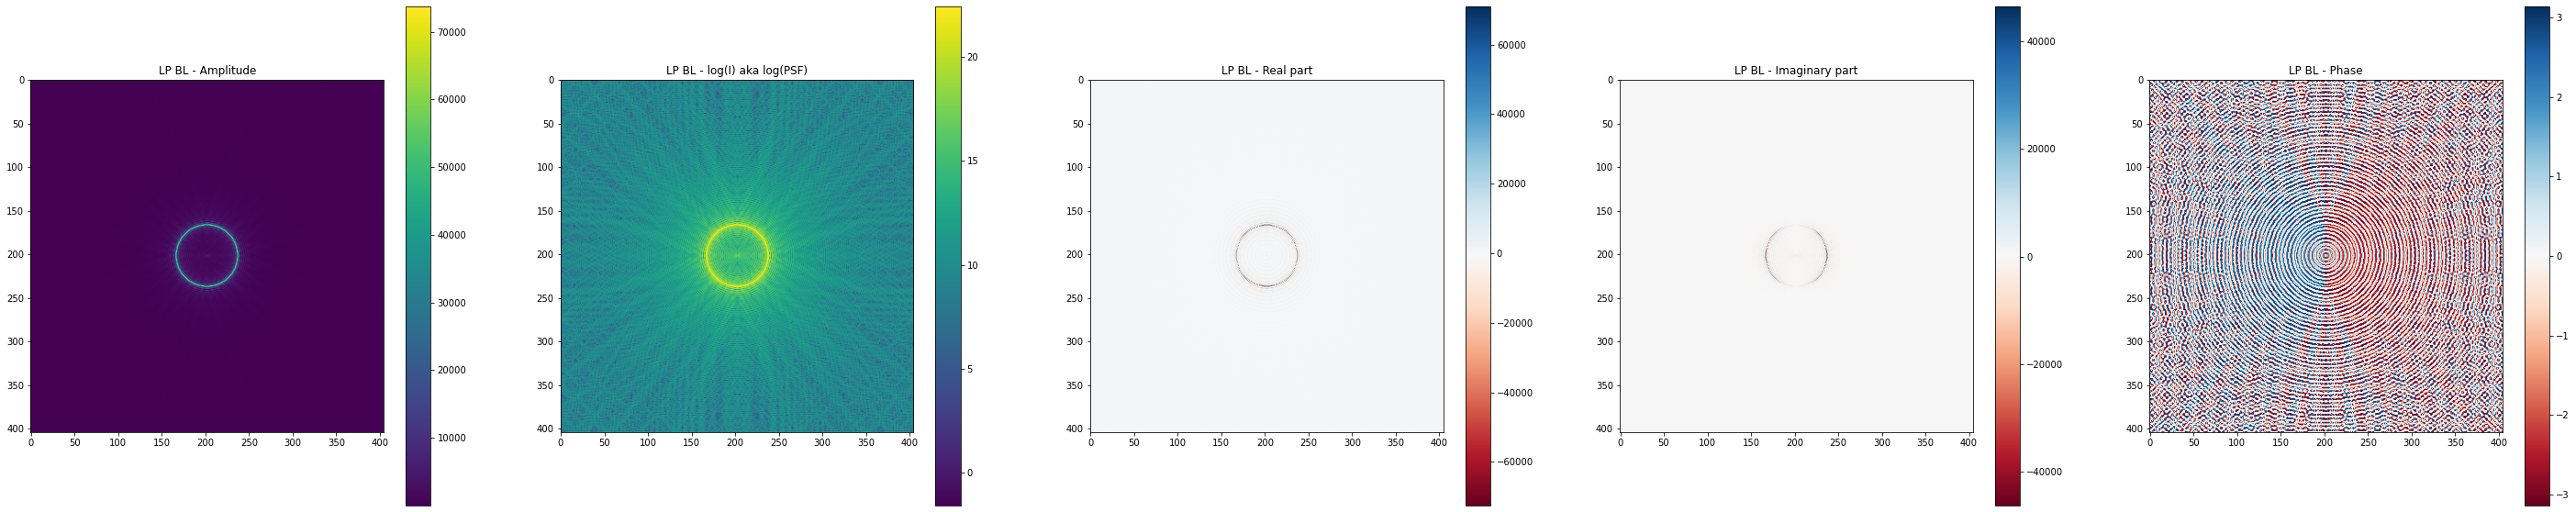

In [102]:
CLC=1-circle_mask(focalplan_BC, int(focalplan_BC.shape[0]/2), int(focalplan_BC.shape[0]/2), rad*0.9)
focalplan_AC=focalplan_BC*CLC
B_Lyot = ft2d(focalplan_AC)

#Box rezize
pad = 5
npix_pad = npix*pad+1   # figure out the padded big array sizes after the FT
zoomfac =10   # half-size of the zoom box will be 1/zoomfac of total image
box = int(npix_pad/zoomfac)

# This is a smaller data array wiht our region of interest.
focalplan_AC_zoom = zoom(focalplan_AC, int(focalplan_AC.shape[0]/2), int(focalplan_AC.shape[0]/2), box)


multi_plot(focalplan_AC_zoom, "FP AC")
multi_plot(B_Lyot, "LP BL")

LyotStop plan

1 TF focal pla after Conagraph

2 Make (Lyotstop) aperture

3 Multiply TF and (Lyotstop) aperture

C:\Users\dbourgeois\Miniconda3\envs\foufourier\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


()

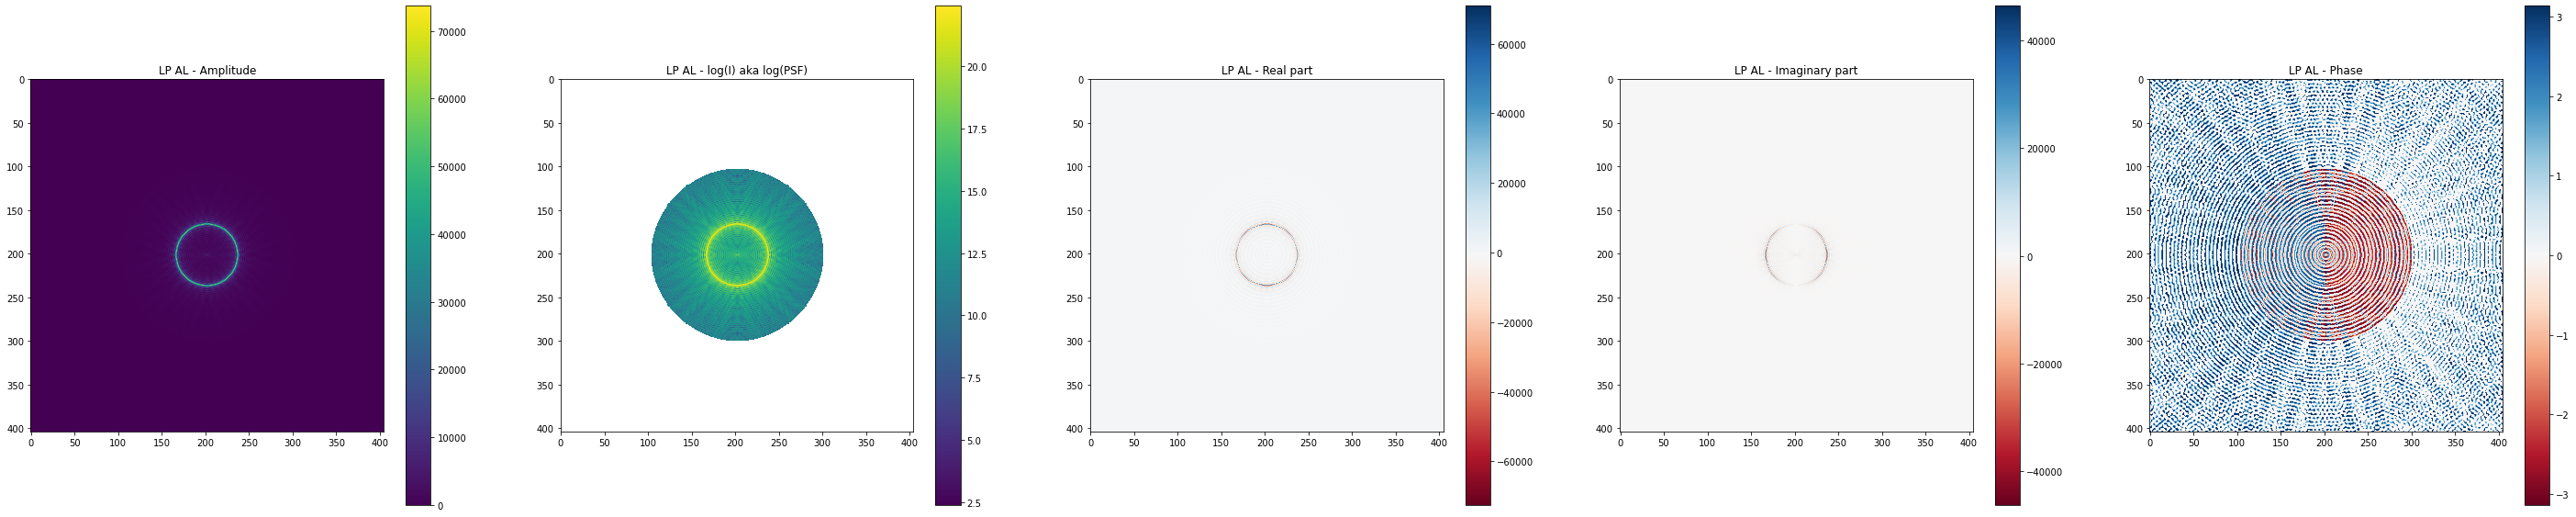

In [103]:
Lyot=circle_mask(B_Lyot, int(B_Lyot.shape[0]/2), int(B_Lyot.shape[0]/2), rad*0.98)
A_Lyot=B_Lyot*Lyot

#Box rezize
pad = 5
npix_pad = npix*pad+1   # figure out the padded big array sizes after the FT
zoomfac =7   # half-size of the zoom box will be 1/zoomfac of total image
box = int(npix_pad/zoomfac)

# This is a smaller data array wiht our region of interest.
A_Lyot_zoom = zoom(A_Lyot, int(A_Lyot.shape[0]/2), int(A_Lyot.shape[0]/2), box)

multi_plot(A_Lyot, "LP AL")

()

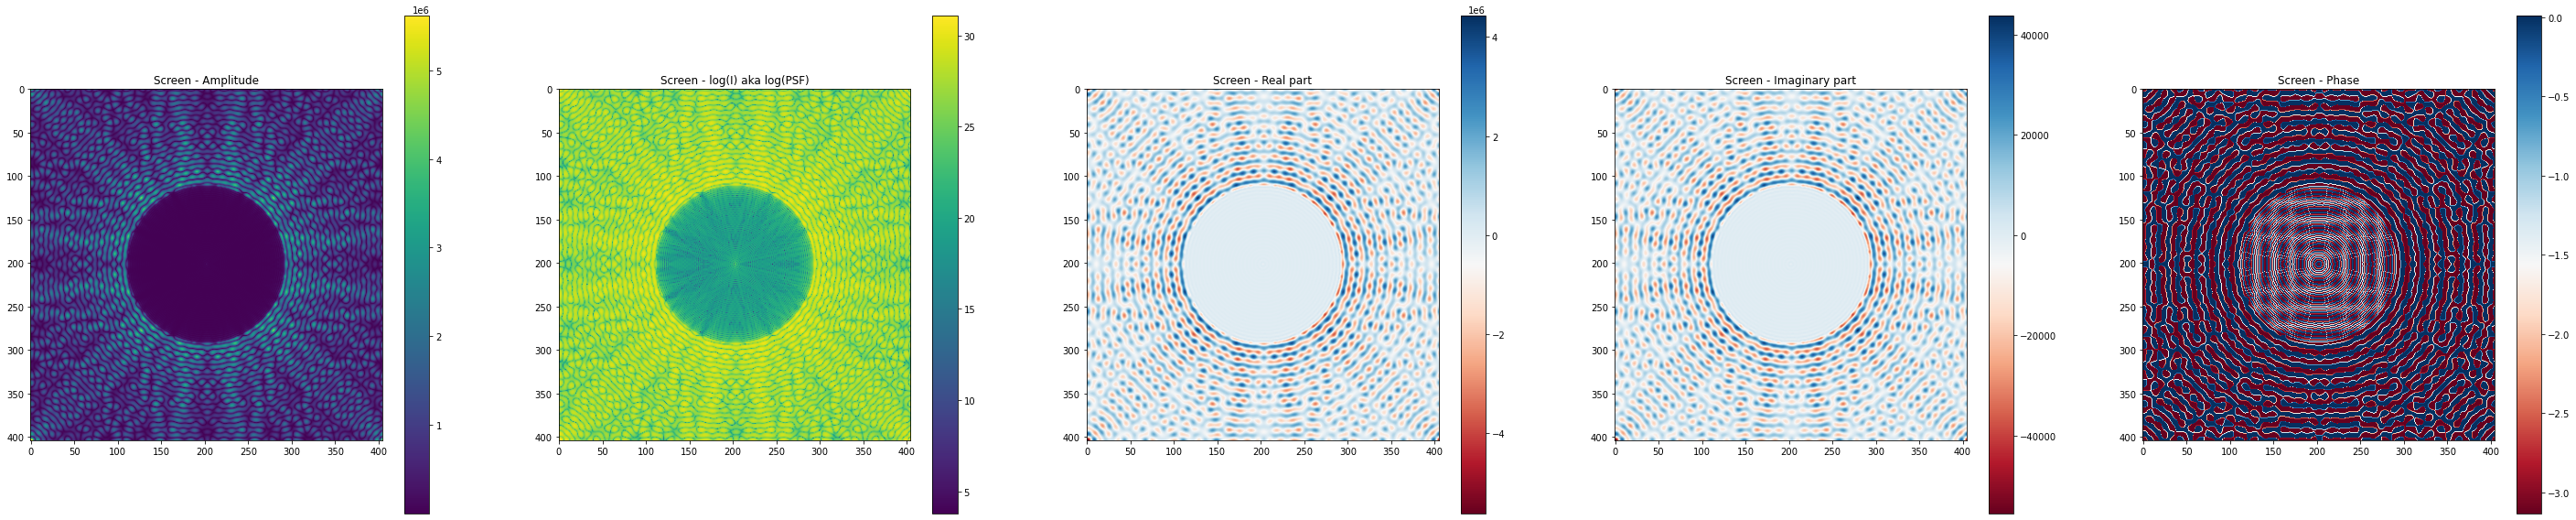

In [104]:
screen=ft2d(A_Lyot)

#Box rezize
pad = 5
npix_pad = npix*pad+1   # figure out the padded big array sizes after the FT
zoomfac =10   # half-size of the zoom box will be 1/zoomfac of total image
box = int(npix_pad/zoomfac)

# This is a smaller data array wiht our region of interest.
screen_zoom = zoom(screen, int(screen.shape[0]/2), int(screen.shape[0]/2), box)

multi_plot(screen, "Screen")


In [ ]:
#PINAL ploting Cell
plt.figure(figsize=(10, 60))
#plt.axis('equal')
#plt.subplots_adjust(wspace=0.5)

font = {' - size'   : 15}

"""
multi_plot(focalplan_BC, "FP BC")
multi_plot(focalplan_AC, "FP AC")
multi_plot(B_Lyot, "LP BL")
multi_plot(A_Lyot, "LP AL")
multi_plot(screen, "Screen")
"""

#func2=[Efield,focalplan_BC,focalplan_AC,B_Lyot,A_Lyot,screen]
func2=[Efield,focalplan_BC]
title2=["PP Eletric field","FP BC","FP AC","LP BL","LP AL","Screen"]

for i in range(2):
    plt.subplot(30, 5, i*5+1)
    plt.imshow(np.abs(func2[i]))
    plt.colorbar()
    plt.title(title2[i]+' - Amplitude')

    plt.subplot(30, 5, i*5+2)
    plt.imshow(np.log(np.abs(func2[i])**2))
    plt.colorbar()
    plt.title(title2[i]+' - log(I) aka log(PSF)')

    plt.subplot(30, 5, i*5+3)
    plt.imshow(np.real(func2[i]),cmap='RdBu')
    plt.colorbar()
    plt.title(title2[i]+' - Real part')

    plt.subplot(30, 5, i*5+4)
    plt.imshow(np.imag(func2[i]),cmap='RdBu')
    plt.colorbar()
    plt.title(title2[i]+' - Imaginary part')

    plt.subplot(30, 5, i*5+5)
    plt.imshow(np.angle(func2[i]) ,cmap='RdBu')
    plt.colorbar()
    plt.title(title2[i]+' - Phase')

print("PP=Pupil Plan, FP=Focal Plan, BC=Before Coronagraph, AC=Before Coronagraph, LP=LyotStop Plan, I=Intensity")